In [1]:
%cd /Users/gwg/dmcm
%matplotlib inline

/Users/gwg/dmcm


In [2]:
import numpy as np
import torch
import random
import matplotlib
import matplotlib.pyplot as plt
from   PIL import Image
from   sklearn.externals import joblib
from   sklearn import preprocessing

from   data import GTExV8Config, GTExV8Dataset, loader
from   models import LeNet5AE, DPCCA

In [3]:
cfg = GTExV8Config()
dataset = GTExV8Dataset(cfg)

In [40]:
path  = '/Users/gwg/dmcm/experiments/20190213_fa/'\
        'gtexv8_mode-pcca_batch_size-128_seed-0_latent_dim-2000_lr-0.001_l1_coef-0.0_em_iters-1_clip-1/'\
        'model.joblib.pkl'
model = joblib.load(path)

N = 1000
images = torch.Tensor(N, 3, 128, 128)
genes  = torch.Tensor(N, cfg.N_GENES)
for i, (x1, x2) in enumerate(dataset):
    if i >= N:
        break
    images[i] = x1
    genes[i]  = x2

x = torch.cat([images.view(-1, 3*128*128), genes], dim=1)

/Users/gwg/miniconda3/envs/dmcm/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator FactorAnalysis from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [41]:
tissues = np.array(dataset.labels)[:N]
# Convert tissue names to integers.
le = preprocessing.LabelEncoder()
labs = le.fit_transform(tissues)

(1000, 2000)


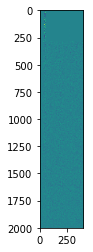

In [43]:
z = model.transform(x)
print(z.shape)

fig, ax = plt.subplots(figsize=(22, 4))
ax.imshow(z[:400].T, interpolation='nearest')

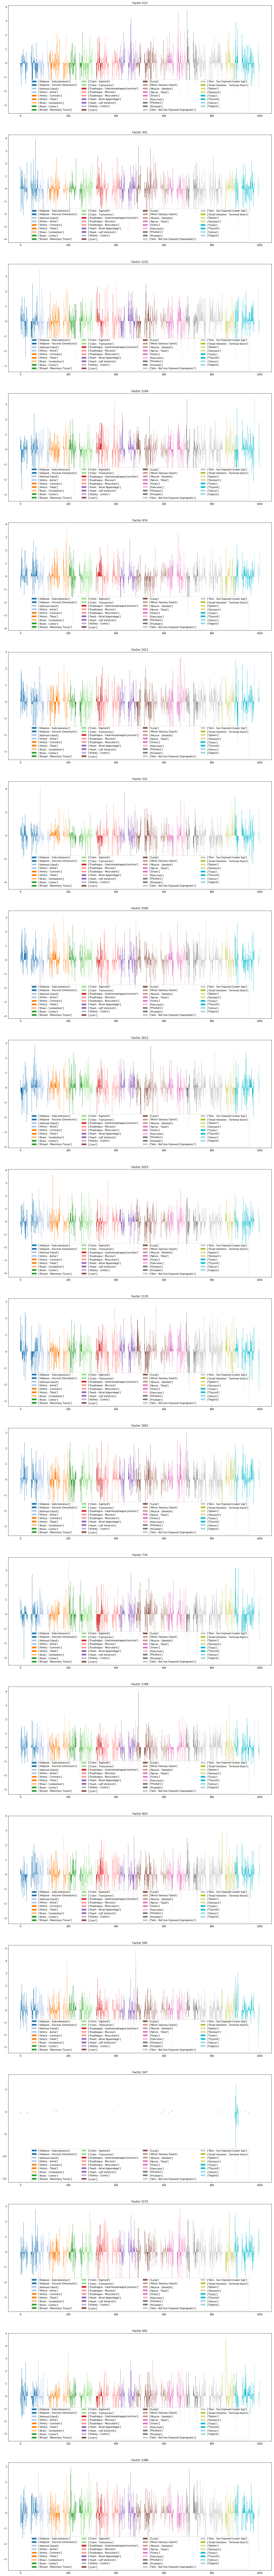

In [44]:
N_RANDOM_FACTORS = 20

fig, axes = plt.subplots(N_RANDOM_FACTORS, 1)
fig.set_size_inches(20, 200)

for i in range(N_RANDOM_FACTORS):
    ax = axes.flat[i]
    factor_idx = random.randint(0, 2000-1)
    z_spec     = z[:, factor_idx]
    inds       = np.argsort(labs)
    z_sorted   = z_spec[inds]
    l_sorted   = labs[inds]

    cmap = plt.cm.get_cmap('tab20', len(np.unique(labs)))

    labels_added = []
    for i, (zi, label) in enumerate(zip(z_sorted, l_sorted)):
        if i > N:
            break
        tiss = le.inverse_transform([label])
        if tiss in labels_added:
            ax.bar(i, zi, color=cmap(label))
        else:
            labels_added.append(tiss)
            ax.bar(i, zi, color=cmap(label), label=tiss)

    ax.set_title('Factor %s' % factor_idx)
    ax.legend(ncol=4, loc='lower center')

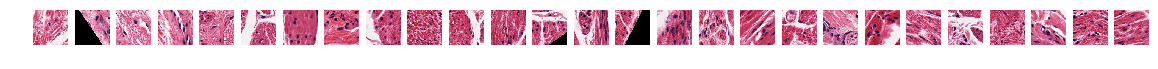

In [45]:
tissue_name = 'Esophagus - Gastroesophageal Junction'
factor_idx  = 874
# tissue_name = 'Nerve - Tibial'

index = None
for i in np.unique(labs):
    tiss = le.inverse_transform([int(i)])[0]
    if tiss == tissue_name:
        index = float(i)
        break

inds = labs == index
images_one_type = images.numpy()[inds]
Zs_one_type     = z[inds]
inds = np.argsort(Zs_one_type[:, factor_idx])

indices = list(range(0, len(inds), 1))
f, axarr = plt.subplots(1, len(indices))
f.set_size_inches(20, 10)
plt.axis('off')

for ax, i in zip(axarr.flat, indices):
    ax.imshow(images_one_type[inds][i].T)
    ax.axis('off')